# Fraction of native contacts over a trajectory

Here, we calculate the native contacts of a trajectory as a fraction of the native contacts in a given reference.

**Last updated:** December 2022 with MDAnalysis 2.4.0-dev0

**Minimum version of MDAnalysis:** 1.0.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisTests
* [matplotlib](https://matplotlib.org)
* [pandas](https://pandas.pydata.org)
* [nglview](http://nglviewer.org/nglview/latest/api.html)

**See also**

* [Contact analysis: number of contacts within a cutoff](contacts_within_cutoff.ipynb) (all contacts within a cutoff)
* [Write your own contacts analysis method](contacts_custom.ipynb)
* [Q1 vs Q2 contact analysis](contacts_q1q2.ipynb)

In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD
from MDAnalysis.analysis import contacts

import nglview as nv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. (<a data-cite="beckstein_zipping_2009" href="https://doi.org/10.1016/j.jmb.2009.09.009">Beckstein *et al.*, 2009</a>)
 The trajectory ``DCD`` samples a transition from a closed to an open conformation.

In [2]:
u = mda.Universe(PSF, DCD)

/home/pbarletta/mambaforge/envs/guide/lib/python3.9/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


## Background

Residues can be determined to be in contact if atoms from the two residues are within a certain distance. *Native* contacts are those contacts that exist within a native state, as opposed to *non-native* contacts, which are formed along the path to a folded state or during the transition between two conformational states. MDAnalysis defines native contacts as those present in the reference structure (`refgroup`) given to the analysis. 

Proteins often have more than one native state. Calculating the fraction of native contacts within a protein over a simulation can give insight into transitions between states, or into folding and unfolding processes. MDAnalysis supports three metrics for determining contacts:

* [Hard distance cutoff (hard_cut_q)](#Hard-cutoff-with-a-single-reference)
* [Radius cutoff (radius_cut_q)](#Radius-cutoff) (<a data-cite="franklin_minactionpath_2007" href="https://doi.org/10.1093/nar/gkm342">Franklin *et al.*, 2007</a>)
* [Soft potential-based cutoff (soft_cut_q)](#Soft-cutoff-and-multiple-references) (<a data-cite="best_native_2013" href="https://doi.org/10.1073/pnas.1311599110">Best *et al.*, 2013</a>)

Please see the API documentation for the [Contacts](https://docs.mdanalysis.org/stable/documentation_pages/analysis/contacts.html#MDAnalysis.analysis.contacts.Contacts) class for more information.

## Defining the groups for contact analysis

For the purposes of this tutorial, we define pseudo-salt bridges as contacts. A more appropriate quantity for studying the transition between two protein conformations may be the contacts formed by alpha-carbon atoms, as this will give us insight into the movements of the protein in terms of the secondary and tertiary structure. The [Q1 vs Q2 contact analysis](contacts_q1q2.ipynb) demonstrates an example using the alpha-carbon atoms.

In [3]:
sel_basic = "(resname ARG LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP GLU) and (name OE* OD*)"
acidic = u.select_atoms(sel_acidic)
basic = u.select_atoms(sel_basic)

## Hard cutoff with a single reference

The `'hard_cut'` or [hard_cut_q()](https://docs.mdanalysis.org/stable/documentation_pages/analysis/contacts.html#MDAnalysis.analysis.contacts.hard_cut_q) method uses a hard cutoff for determining native contacts. Two residues are in contact if the distance between them is lower than or equal to the distance in the reference structure.

Below, we use the atomgroups in the universe at the current frame as a reference.

In [4]:
ca1 = contacts.Contacts(u, 
                        select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic), 
                        radius=4.5, 
                        method='hard_cut').run()

The results are available as a numpy array at `ca1.timeseries`. The first column is the frame, and the second is the fraction of contacts present in that frame.

In [5]:
ca1_df = pd.DataFrame(ca1.results.timeseries, 
                      columns=['Frame', 
                               'Contacts from first frame'])
ca1_df.head()

,Frame,Contacts from first frame
0,0.0,1.000000
1,1.0,0.492754
2,2.0,0.449275
3,3.0,0.507246
4,4.0,0.463768


Note that the data is presented as fractions of the native contacts present in the reference configuration. In order to find the number of contacts present, multiply the data with the number of contacts in the reference configuration. Initial contact matrices are saved as pairwise arrays in `ca1.initial_contacts`.

In [6]:
ca1.initial_contacts[0].shape

(70, 44)

You can sum this to work out the number of contacts in your reference, and apply that to the fractions of references in your `timeseries` data.

In [7]:
n_ref = ca1.initial_contacts[0].sum()
print('There are {} contacts in the reference.'.format(n_ref))

There are 69 contacts in the reference.


In [8]:
n_contacts = ca1.results.timeseries[:, 1] * n_ref
print(n_contacts[:5])

[69. 34. 31. 35. 32.]


### Plotting

You can plot directly from the dataframe, or use other tools such as [seaborn](https://seaborn.pydata.org/). In this trajectory, the fraction of native contats drops immediately to under 50%, and fluctuates around 40% for the rest of the simulation. This means that the protein retains a structure where around 40% salt bridges in the reference remain within the distance of the reference. However, it is difficult to infer information on domain rearrangements and other large-scale movement, other than that the the protein never returns to a similar state as the initial frame.

Text(0, 0.5, 'Fraction of contacts')

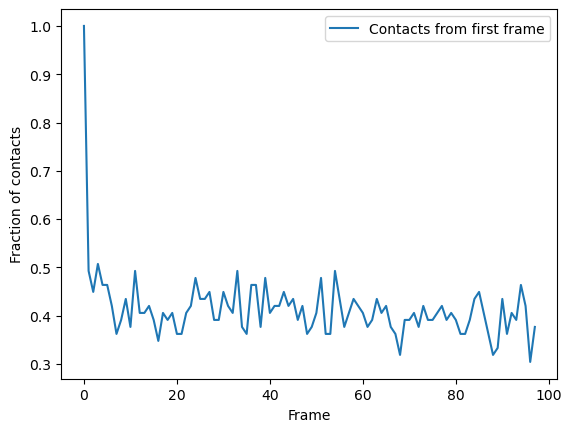

In [19]:
ca1_df.plot(x='Frame')
plt.ylabel('Fraction of contacts')

## Radius cutoff

Another metric that MDAnalysis supports is determining residues to be in contact if they are within a certain radius. This is similar to the hard cutoff metric, in that there is no potential. The difference is that a single radius is used as the cutoff for all contacts, rather than the distance between the residues in the reference. For a tutorial on similar contact analysis of residues within a cutoff, see [Number of contacts within cutoff](contacts_within_cutoff.ipynb). That tutorial is for calculating the overall number or fraction of contacts, instead of the fraction of native contacts.

You can choose this method by passing in the method name `'radius_cut'`, which uses the [radius_cut_q()](https://docs.mdanalysis.org/stable/documentation_pages/analysis/contacts.html#MDAnalysis.analysis.contacts.radius_cut_q). The `radius` keyword specifies the distance used in ångström. No other arguments need to passed into `kwargs`.

In [10]:
ca2 = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic), 
                        radius=4.5, 
                        method='radius_cut').run()

### Plotting

Again, we can plot over time. We can see that the fraction of native contacts from the first frame has a very different shape for the `radius_cut` method vs the `hard_cut` method. While the `hard_cut` metric tells us that >50% the native contacts never have equal or lower distance during the trajectory, as compared to the reference, the `radius_cut` analysis shows us that the fraction of contacts within 4.5 Å decreases gradually to 75% over the trajectory. We can infer that almost half the native contacts in the reference frame were closer than 4.5 Å. Moreover, the continuous decrease suggests that the protein may be unfolding, or a large-scale changes in conformation are occurring in such a way that the native salt bridges are not preserved or re-formed.

Text(0, 0.5, 'Fraction of contacts')

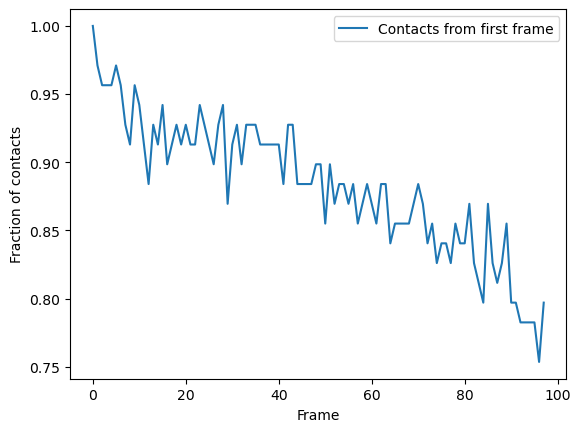

In [11]:
ca2_df = pd.DataFrame(ca2.results.timeseries, 
                      columns=['Frame', 'Contacts from first frame'])
ca2_df.plot(x='Frame')
plt.ylabel('Fraction of contacts')

## Soft cutoff and multiple references

### Multiple references

`refgroup` can either be two contacting groups in a reference configuration, or a list of tuples of two contacting groups. 

Below we want to look at native contacts from the first frame, and the last frame. To do this, we create a new universe called `ref` with the same files (and therefore same data) as `u`. We need to do this so that the (`acidic, basic`) selections from `u`, which are assigned from the first frame, remain unchanged. `ref` is a different Universe so when we set it to its last frame (with index `-1`), it does not affect `u` or the previous selections. Now, when we re-select the atomgroups from `ref` with the selection string used in the [hard-cutoff section](#Hard-cutoff-with-a-single-reference), different contacts are selected to the contacts found in the first frame of `u`.

In [12]:
ref = mda.Universe(PSF, DCD)

ref.trajectory[-1]
acidic_2 = ref.select_atoms(sel_acidic)
basic_2 = ref.select_atoms(sel_basic)

/home/pbarletta/mambaforge/envs/guide/lib/python3.9/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


### Soft cutoff

This time we will use the [soft_cut_q](https://docs.mdanalysis.org/stable/documentation_pages/analysis/contacts.html#MDAnalysis.analysis.contacts.soft_cut_q) algorithm to calculate contacts by setting `method='soft_cut'`. This method uses the soft potential below to determine if atoms are in contact:

$$ Q(r, r_0) = \frac{1}{1 + e^{\beta (r - \lambda r_0)}} $$

$r$ is a distance array and $r0$ are the distances in the reference group. $\beta$ controls the softness of the switching function and $\lambda$ is the tolerance of the reference distance.

Suggested values for $\lambda$ is 1.8 for all-atom simulations and 1.5 for coarse-grained simulations. The default value of $\beta$ is 5.0. To change these, pass `kwargs` to contacts.Contacts. We also pass in the contacts from the first frame (`(acidic, basic)`) and the last frame (`(acidic_2, basic_2)`) as two separate reference groups. This allows us to calculate the fraction of native contacts in the first frame and the fraction of native contacts in the last frame simultaneously.

In [13]:
ca3 = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=[(acidic, basic), (acidic_2, basic_2)], 
                        radius=4.5, 
                        method='soft_cut',
                        kwargs={'beta': 5.0,
                                'lambda_constant': 1.5}).run()

Again, the first column of the data array in `ca2.timeseries` is the frame. The next columns of the array are fractions of native contacts with reference to the `refgroup`s passed, in order.

In [14]:
ca3_df = pd.DataFrame(ca3.results.timeseries, 
                      columns=['Frame', 
                               'Contacts from first frame', 
                               'Contacts from last frame'])
ca3_df.head()

,Frame,Contacts from first frame,Contacts from last frame
0,0.0,0.999094,0.719242
1,1.0,0.984928,0.767501
2,2.0,0.984544,0.788027
3,3.0,0.970184,0.829219
4,4.0,0.980425,0.833500


### Plotting

Again, we can see that the fraction of native contacts from the first frame has a very different shape for the `soft_cut` method vs the other methods. Like the `radius_cut` method, a gradual decrease in salt bridges is visible; unlike that plot, however, more than 80% native contacts are counted by 100 frames using this metric. By itself, this analysis might suggest that the protein is unfolding.

More interesting is the fraction of native contacts from the *last* frame, which rises from ~70% to 100% over the simulation. This rise indicates that the protein is not *unfolding*, per se (where contacts from the last frame would be expected to rise much less); but instead, a rearrangement of the domains is occurring, where new contacts are formed in the final state.

<AxesSubplot: xlabel='Frame'>

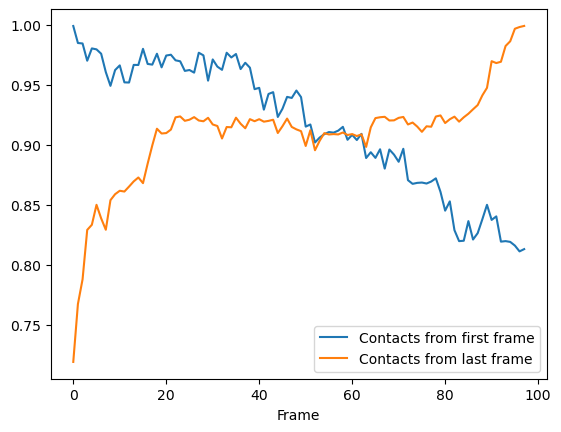

In [15]:
ca3_df.plot(x='Frame')

Indeed, viewing the trajectory shows us that the enzyme transitions from a closed to open state.

In [16]:
u.trajectory[0]  # set trajectory to first frame (closed)
# make a new Universe with coordinates of first frame
adk_closed = mda.Merge(u.atoms).load_new(u.atoms.positions)
nv.show_mdanalysis(adk_closed)

NGLWidget()

In [17]:
u.trajectory[-1]  # set trajectory to last frame (open)
# make a new Universe with coordinates of last frame
adk_open = mda.Merge(u.atoms).load_new(u.atoms.positions)
nv.show_mdanalysis(adk_open)

NGLWidget()

We can also plot the fraction of salt bridges from the first frame, over the fraction from the last frame, as a way to characterise the transition of the protein from closed to open.

Text(0, 0.5, 'Contacts from last frame')

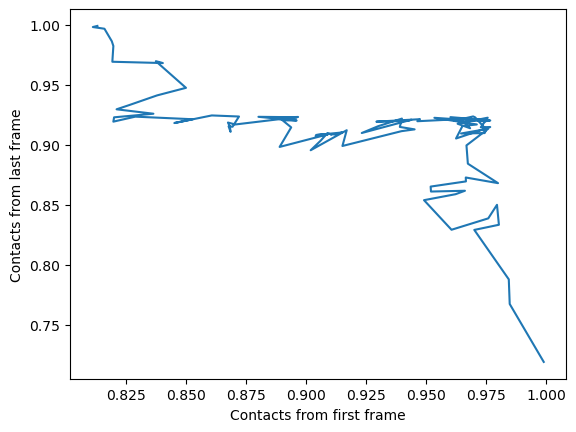

In [18]:
ca3_df.plot(x='Contacts from first frame', 
            y='Contacts from last frame', 
            legend=False)
plt.ylabel('Contacts from last frame')

## References

[1] Oliver Beckstein, Elizabeth&nbsp;J. Denning, Juan&nbsp;R. Perilla, and Thomas&nbsp;B. Woolf.
Zipping and <span class="bibtex-protected">Unzipping</span> of <span class="bibtex-protected">Adenylate</span> <span class="bibtex-protected">Kinase</span>: <span class="bibtex-protected">Atomistic</span> <span class="bibtex-protected">Insights</span> into the <span class="bibtex-protected">Ensemble</span> of <span class="bibtex-protected">Open</span>↔<span class="bibtex-protected">Closed</span> <span class="bibtex-protected">Transitions</span>.
<em>Journal of Molecular Biology</em>, 394(1):160–176, November 2009.
00107.
URL: <a href="https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164">https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164</a>, <a href="https://doi.org/10.1016/j.jmb.2009.09.009">doi:10.1016/j.jmb.2009.09.009</a>.

[2] R.&nbsp;B. Best, G.&nbsp;Hummer, and W.&nbsp;A. Eaton.
Native contacts determine protein folding mechanisms in atomistic simulations.
<em>Proceedings of the National Academy of Sciences</em>, 110(44):17874–17879, October 2013.
00259.
URL: <a href="http://www.pnas.org/cgi/doi/10.1073/pnas.1311599110">http://www.pnas.org/cgi/doi/10.1073/pnas.1311599110</a>, <a href="https://doi.org/10.1073/pnas.1311599110">doi:10.1073/pnas.1311599110</a>.

[3] Joel Franklin, Patrice Koehl, Sebastian Doniach, and Marc Delarue.
<span class="bibtex-protected">MinActionPath</span>: maximum likelihood trajectory for large-scale structural transitions in a coarse-grained locally harmonic energy landscape.
<em>Nucleic Acids Research</em>, 35(suppl_2):W477–W482, July 2007.
00083.
URL: <a href="https://academic.oup.com/nar/article-lookup/doi/10.1093/nar/gkm342">https://academic.oup.com/nar/article-lookup/doi/10.1093/nar/gkm342</a>, <a href="https://doi.org/10.1093/nar/gkm342">doi:10.1093/nar/gkm342</a>.

[4] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[5] Naveen Michaud-Agrawal, Elizabeth&nbsp;J. Denning, Thomas&nbsp;B. Woolf, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> toolkit for the analysis of molecular dynamics simulations.
<em>Journal of Computational Chemistry</em>, 32(10):2319–2327, July 2011.
00778.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21787">http://doi.wiley.com/10.1002/jcc.21787</a>, <a href="https://doi.org/10.1002/jcc.21787">doi:10.1002/jcc.21787</a>.